### Importing libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image
from sklearn.model_selection import  train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D

In [ ]:
from keras.models import load_model

### Utility Functions

In [3]:
# Data sets summary
def info_dataset(X_train, X_valid, y_train):
    # Number of training examples
    n_train = X_train.shape[0]

    # Number of validation examples
    n_validation = X_valid.shape[0]

    # Shape of an traffic sign image
    image_shape = X_train[0].shape

    # Unique classes/labels in the dataset.
    n_classes = max(y_train)+1

    print("Number of training examples =", n_train)
    print("Number of validation examples =", n_validation)
    print("Image data shape =", image_shape)
    print("Number of classes =", n_classes)

In [4]:
# Data sets visualization    
def viz_dataset(X_train, y_train, X_valid, y_valid):

    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5), sharex=True)
    n_classes = int(max(y_train)+1)

    # Histogram of the data
    print("Frequency histogram of traffic signs in datasets\n")

    msg=['Training Dataset','Validation Dataset']
    num_bins = n_classes
    num_maxfreq = 5

    n0, bins0, patches=ax0.hist(y_train, num_bins, facecolor='g', alpha=0.65)
    ax0.set_title(msg[0])
    ax0.set_ylabel('Frequency')

    n1, bins1, patches=ax1.hist(y_valid, num_bins, facecolor='b', alpha=0.65)
    ax1.set_title(msg[1])
    ax1.set_xlabel('Labels')

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.show()

    sort_n0=np.argsort(n0,axis=-1)
    sort_n1=np.argsort(n1,axis=-1)

    maxfreq_labels=[]
    maxfreq_labels=[sort_n0[n_classes-num_maxfreq:]]
    maxfreq_labels=np.append(maxfreq_labels,[sort_n1[n_classes-num_maxfreq:]],axis=0)

    print("Traffic signs with more examples in datasets\n")

    for i,j in enumerate(maxfreq_labels):
        fig, ax = plt.subplots(ncols=num_maxfreq, figsize=(15, 4))
        fig.tight_layout()
        for k in range(num_maxfreq):
            val = j[num_maxfreq-(1+k)]
            ind = np.max(np.where(y_valid==val))
            image = X_valid[ind].squeeze()
            ax[k].imshow(image, cmap="gray")
            ax[k].set_title('Label: '+ str(y_valid[ind]))
            ax[k].axis('off')
        fig.suptitle(msg[i])

In [5]:
# Data set pre-processing 
def RGB2GREY(data_RGB):
    
    n_data=data_RGB.shape[0]
    data_gr=np.zeros((n_data,32,32,1))
    for i in range(n_data):
        tmp = cv2.cvtColor(data_RGB[i], cv2.COLOR_RGB2GRAY)
        data_gr[i]= np.reshape(tmp,(32,32,1))
    
    return data_gr

In [6]:
# Generate more image examples to balance the dataset
def expand_dataset(data_gr,data_labels):
    
    n_data=data_gr.shape[0]
    
    p_insts=np.zeros(n_classes)
    for i in range(n_classes):
        sum_ints = np.sum(data_labels==i)
        p_insts[i] = sum_ints/n_data
    
    n_aug=int(1.0*n_data)
    aug_X=np.array(np.zeros((n_aug,32,32,1)))
    aug_y=np.array(np.zeros((n_aug)))
    for i in range(n_aug):
        index = random.randint(0, n_data-1)
        aug_X[i]=data_gr[index]
        aug_y[i]=data_labels[index]
        p_trigg = random.uniform(1/np.max(p_insts),1/np.min(p_insts))
        while p_insts[int(aug_y[i])]*p_trigg>1.05: # Generate more data for those classes with less representation
            index = random.randint(0, n_data-1)
            aug_X[i]=data_gr[index]
            aug_y[i]=data_labels[index]
            sum_ints=np.sum(data_labels==aug_y[i])
            p_trigg = random.uniform(1/np.max(p_insts),1/np.min(p_insts))

    for i in range(n_aug):
        n = random.randint(2,4)
        rot = random.randint(-20, 20)
        M = cv2.getRotationMatrix2D((32/n,32/n),rot,1)
        tmp = cv2.warpAffine(aug_X[i],M,(32,32))
        
        noise = 10*np.random.random((32, 32))
        tmp = tmp+noise
        aug_X[i] = np.reshape(tmp,(32,32,1))
    
    return aug_X, aug_y

In [7]:
#Normalisation
def norm_data(data_gr):
    
    return (data_gr-128)/128

### HELPER FUNCTIONS

In [8]:
#class MetricsCheckpoint(Callback):
 #  def __init__(self, savepath):
  #      super(MetricsCheckpoint, self).__init__()
   #     self.savepath = savepath
    #    self.history = {}
    #def on_epoch_end(self, epoch, logs=None):
     #   for k, v in logs.items():
      #      self.history.setdefault(k, []).append(v)
       # np.save(self.savepath, self.history)
        
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
     
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

###  Plotting 12 images to check dataset

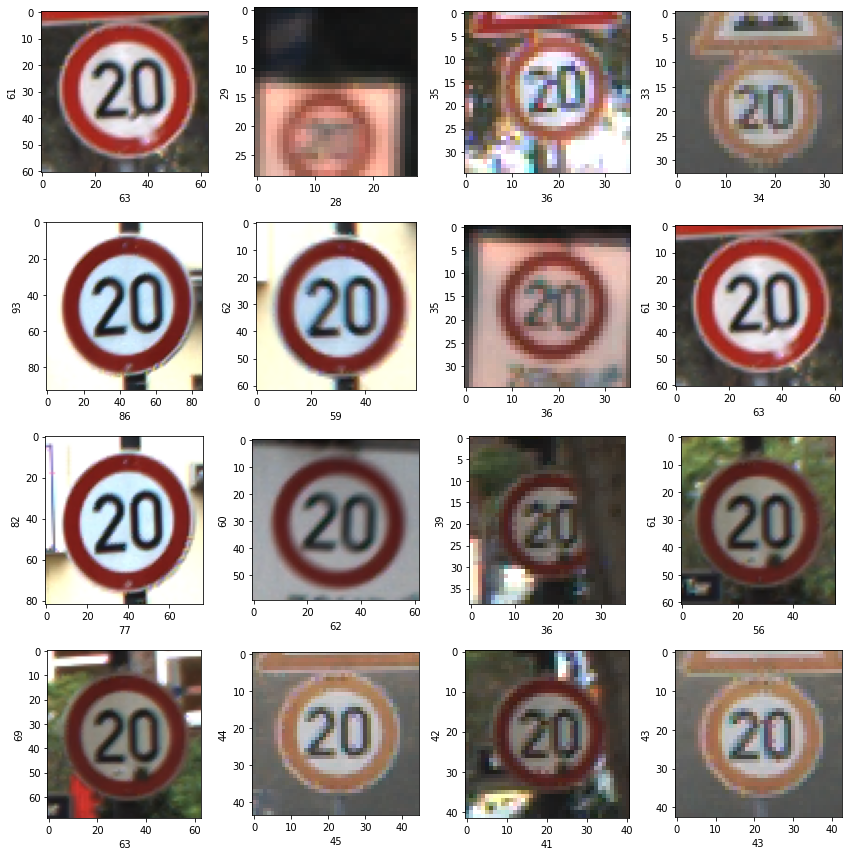

In [9]:
# Error because of .DS_store file
plt.figure(figsize=(12,12))
path = "../data/final_sign_images/Train/0" #Not able to push data to git, give local file path
#path = "./data/German_final_dataset/Train/0"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

### Finding mean of dimensions

In [10]:
dim1 = []
dim2 = []
images = []
label_id = []

for i in range(0,43):
    labels = '../data/final_sign_images/Train/'+ str(i)#Not able to push data to git, give local file path
    #labels = './data/German_final_dataset/Train/'+ str(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = imread(labels + '/' + x)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])
        img = np.array(img)
        images.append(img)
        label_id.append(i)

In [11]:
#Printing mean dimension of images
print("Dimension 1 Mean : ",np.mean(dim1), " Dimension 2 Mean : ",np.mean(dim2))

Dimension 1 Mean :  50.328929582493814  Dimension 2 Mean :  50.83587951745773


In [12]:
#dim1 = []
data = []
images = []
labels = []

for i in range(0,43):
    path = '../data/final_sign_images/Train/'+ str(i)#Not able to push data to git, give local file path
    #path = './data/German_final_dataset/Train/'+ str(i)
    image_path = os.listdir(path)
    for a in image_path:
        link_to_image = str(path + '/'+ a)
        img = Image.open(link_to_image)
        img = img.resize((50,50))
        img = np.array(img)
        data.append(img)
        labels.append(i)
data = np.array(data)
labels = np.array(labels)
        

       
    
    
        
       

In [13]:
data.shape

(39209, 50, 50, 3)

In [14]:
labels.shape

(39209,)

In [15]:
label_counts = pd.DataFrame(labels).value_counts()
label_counts

2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
3     1410
8     1410
11    1320
35    1200
18    1200
17    1110
31     780
14     780
33     689
15     630
26     600
28     540
23     510
30     450
16     420
34     420
6      420
36     390
22     390
40     360
20     360
21     330
39     300
29     270
24     270
41     240
42     240
32     240
27     240
37     210
19     210
0      210
dtype: int64

### Splitting the data

In [16]:
X_train, X_val, y_train, y_val = train_test_split(data, labels , test_size = 0.2, random_state = 42)

In [17]:
print(X_train.shape, X_val.shape, y_train.shape,y_val.shape)

(31367, 50, 50, 3) (7842, 50, 50, 3) (31367,) (7842,)


In [18]:
y_train = to_categorical(y_train,43)
y_val = to_categorical(y_val,43)

In [19]:
X_train.shape[1:]

(50, 50, 3)

In [20]:
# model B is giving a higher accuracy
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

In [23]:
# model A
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = X_train.shape[1:], activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation = 'softmax'))

In [21]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [32]:
#this function does not creade ta .h5 file for current model
number_of_epochs = 2
for i in range(1,number_of_epochs):
    model.fit(X_train, y_train, epochs = i , batch_size = 32, validation_data = (X_val, y_val), verbose = 2)
    print(i)
    if(i >= 2 and val_accuracy[i] >= val_accuracy[i-1]):
        model.save('./my_model.h5') 
        


981/981 - 92s - loss: 0.1873 - accuracy: 0.9435 - val_loss: 0.0596 - val_accuracy: 0.9861
1


In [35]:
model.fit(X_train, y_train, epochs = 2 , batch_size = 32, validation_data = (X_val, y_val), verbose = 2)

model.save('./models/my_model.h5')

Epoch 1/2
981/981 - 94s - loss: 0.1674 - accuracy: 0.9485 - val_loss: 0.0602 - val_accuracy: 0.9848
Epoch 2/2
981/981 - 95s - loss: 0.1528 - accuracy: 0.9543 - val_loss: 0.0440 - val_accuracy: 0.9889


### Visualizations of image data

In [ ]:
num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
          axs[j][i].set_title(str(j) + " - " + row["SignName"])
          num_of_samples.append(len(x_selected))

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [ ]:
info_dataset(X_train, X_valid, y_train)

In [ ]:
viz_dataset(X_train, y_train, X_valid, y_valid)

### Data Preprocessing

In [ ]:
n_classes = int(max(y_train)+1)

# Train data set shuffling
X_train, y_train = shuffle(X_train, y_train)

# Data set RGB images to gray scale
nX_train=RGB2GREY(X_train)
nX_valid=RGB2GREY(X_valid)

# Train data set augmentation with image rotation
aug_X, aug_y=expand_dataset(nX_train, y_train)
nX_train=np.concatenate((nX_train,aug_X))
y_train=np.concatenate((y_train,aug_y))

print("Number of training examples with augmented data=", nX_train.shape[0])
print()

# Data set normalization
nX_train=norm_data(nX_train)
nX_valid=norm_data(nX_valid)

# New data set visualization
viz_dataset(nX_train, y_train, nX_valid, y_valid)

### Convolutional Neural Network Architecture

### Evaluation of model

In [ ]:
evaluation = pd.DataFrame(model.history.history)
evaluation[['accuracy', 'val_accuracy']].plot()
evaluation[['loss', 'val_loss']].plot()

### Test model on real images

In [ ]:
#fetch image

import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [ ]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

In [ ]:
#Test image
print("The Predicted sign: "+ str(model.predict_classes(img)))

### Save model

In [ ]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model # deletes the existing model